In [1]:
import warnings
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wqet_grader
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Extract neighborhood
    df['neighborhood']= df['place_with_parent_names'].str.split('|',expand=True)[3]
    df.drop(columns='place_with_parent_names', inplace=True)

    return df

In [3]:
# Use glob to create a list that contains the filenames for all the Buenos Aires real estate CSV files in the data directory. 
# Assign this list to the variable name files.

files=glob('data/buenos-aires-real-estate-*.csv')
files

# Check your work
# assert len(files) == 2, f"`files` should contain 5 items, not {len(files)}"

['data\\buenos-aires-real-estate-1.csv',
 'data\\buenos-aires-real-estate-2.csv']

In [4]:
# Use your wrangle function in a for loop to create a list named frames. The list should the cleaned DataFrames created 
# from the CSV filenames your collected in files.
frames=[]
for file in files :
    df=wrangle(file)
    frames.append(df)

In [5]:
df=frames[0]


In [6]:
# Use pd.concat to concatenate the items in frames into a single DataFrame df. Make sure you set the ignore_index argument to True.
df=pd.concat(frames, ignore_index=True)
df.shape

(2658, 17)

In [7]:
# Create your feature matrix X_train and target vector y_train. 
# X_train should contain one feature: "neighborhood". Your target is "price_aprox_usd".
target = "price_aprox_usd"
features = ["neighborhood"]
y_train = df[target]
X_train = df[features]

In [8]:
# Calculate the baseline mean absolute error for your model.
y_mean = y_train.mean()
y_pred_baseline = [y_mean]* len(y_train)
print("Mean apt price:", y_mean)
print("Baseline MAE:", mean_absolute_error(y_train,y_pred_baseline))

Mean apt price: 134732.97340481562
Baseline MAE: 45422.75166805662


In [9]:
# First, instantiate a OneHotEncoder named ohe. Make sure to set the use_cat_names argument to True. 
# Next, fit your transformer to the feature matrix X_train. 
# Finally, use your encoder to transform the feature matrix X_train, and assign the transformed data to the variable XT_train
# X_train.head()

# instantiate
ohe=OneHotEncoder(use_cat_names=True)
# Fit
ohe.fit(X_train)
# Transform
XT_train=ohe.transform(X_train)
print(XT_train.shape)
XT_train.head()



(2658, 54)


,neighborhood_Chacarita,neighborhood_Villa Luro,neighborhood_Caballito,neighborhood_Constitución,neighborhood_Once,neighborhood_Almagro,neighborhood_Palermo,neighborhood_Flores,neighborhood_Belgrano,neighborhood_Liniers,...,neighborhood_Retiro,neighborhood_Versalles,neighborhood_Boca,neighborhood_Puerto Madero,neighborhood_Agronomía,neighborhood_Monte Castro,neighborhood_Tribunales,neighborhood_Villa Santa Rita,neighborhood_Velez Sarsfield,neighborhood_Villa Soldati
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Create a pipeline named model that contains a OneHotEncoder transformer and a LinearRegression predictor. 
# Then fit your model to the training data.

model=make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('ridge', Ridge())])

In [11]:
# First, create a list of predictions for the observations in your feature matrix X_train. Name this list y_pred_training. 
# Then calculate the training mean absolute error for your predictions in y_pred_training as compared to the true targets in y_train.

y_pred_training=model.predict(X_train)
mae_training=mean_absolute_error(y_train,y_pred_training)
print("Training MAE: ",round(mae_training,2))

Training MAE:  39518.21


In [12]:
# Extract the intercept and coefficients for your model.
intercept = model.named_steps['ridge'].intercept_.round(2)
coefficients = model.named_steps['ridge'].coef_.round(2)
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 54
[ -4899.55   2426.46   6198.22 -34735.62  -7939.41]


In [13]:
# Extract the feature names of your encoded data from the OneHotEncoder in your model
feature_names = model.named_steps['onehotencoder'].get_feature_names()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 54
['neighborhood_Chacarita' 'neighborhood_Villa Luro'
 'neighborhood_Caballito' 'neighborhood_Constitución' 'neighborhood_Once']


In [14]:
# Create a pandas Series named feat_imp where the index is your features and the values are your coefficients.
feat_imp=pd.Series(coefficients,index=feature_names)
feat_imp.head()

neighborhood_Chacarita       -4899.55
neighborhood_Villa Luro       2426.46
neighborhood_Caballito        6198.22
neighborhood_Constitución   -34735.62
neighborhood_Once            -7939.41
dtype: float64

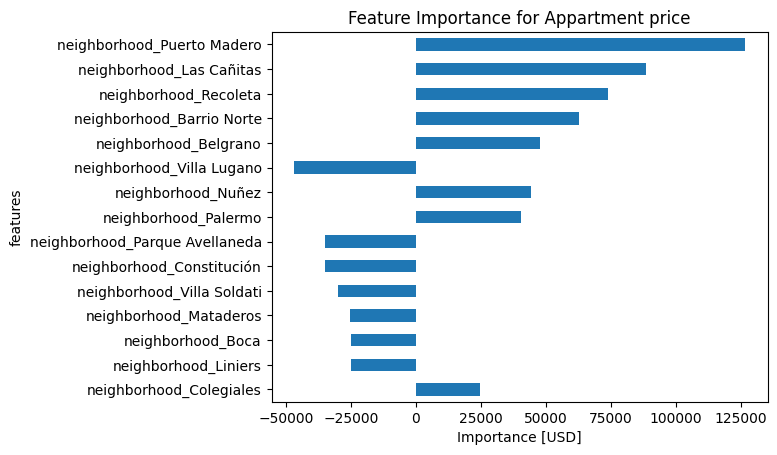

In [15]:
# Create a horizontal bar chart that shows the top 15 coefficients for your model, based on their absolute value.
feat_imp.sort_values(key=abs).tail(15).plot(kind='barh')
plt.xlabel("Importance [USD]")
plt.ylabel("features")
plt.title("Feature Importance for Appartment price");